# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [28]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_dependency_ecosystem"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,...,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000
mean,0.715633,0.815345,0.542848,0.327010,0.368093,0.116051,0.313138,0.245458,0.220811,0.393878,...,0.188078,0.302448,0.063116,0.108415,0.052536,0.096601,0.135184,0.115859,0.062972,0.077380
std,0.407933,0.282321,0.473776,0.448045,0.205063,0.067796,0.173791,0.182952,0.201713,0.219108,...,0.147767,0.193840,0.113180,0.160227,0.113795,0.172470,0.105507,0.104483,0.130304,0.144173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.800000,0.000000,0.000000,0.197221,0.075257,0.192488,0.093193,0.000000,0.232456,...,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.058100,0.037447,0.000000,0.000000
50%,0.952381,0.928571,0.833333,0.000000,0.363611,0.075257,0.323881,0.240899,0.184091,0.391132,...,0.178763,0.310134,0.000000,0.000000,0.000000,0.000000,0.112566,0.089414,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.918033,0.523389,0.119279,0.441188,0.388606,0.376233,0.543241,...,0.296920,0.450264,0.117002,0.202881,0.000000,0.138630,0.189063,0.165960,0.038858,0.094846
max,1.000000,1.000000,1.000000,1.000000,0.980358,0.898782,0.996338,0.741272,0.966097,1.000000,...,0.854348,0.886728,1.000000,1.000000,1.000000,1.000000,0.870413,0.865460,0.912889,0.918738


In [29]:
# Drops all ecosystem fields.

from python_proj.utils.util import get_matching
dropped_fields = list(get_matching(independent_fields, r'((?!.*Dependency).*(?=Ecosystem).*|.*Weighted.*|.*LinkIntensity.*)'))
print(f'{len(dropped_fields)=}')
print(f'{dropped_fields=}')

df = df.drop(dropped_fields, axis=1)
independent_fields = [field for field in independent_fields if field not in dropped_fields]

df.describe()

len(dropped_fields)=9
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + WeightedFirstOrderInDegreeCentrality)', 'ln(1 + WeightedFirstOrderOutDegreeCentrality)', 'ln(1 + IntegratorToSubmitterLinkIntensity)', 'ln(1 + SubmitterToIntegratorLinkIntensity)']


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),...,ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)
count,2.230290e+05,2.230290e+05,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,...,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000
mean,1.670070e+08,3.266915e+06,611.503419,0.715633,0.542848,0.327010,0.368093,0.116051,0.313138,0.245458,...,0.178608,0.160596,0.127950,0.121678,0.099586,0.181625,0.063116,0.108415,0.052536,0.096601
std,9.695130e+07,5.861662e+06,1639.543815,0.407933,0.473776,0.448045,0.205063,0.067796,0.173791,0.182952,...,0.199347,0.198152,0.201176,0.203474,0.146404,0.209267,0.113180,0.160227,0.113795,0.172470
min,6.235100e+04,4.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.476893e+07,2.473630e+05,44.000000,0.500000,0.000000,0.000000,0.197221,0.075257,0.192488,0.093193,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.612981e+08,1.006620e+06,169.000000,0.952381,0.833333,0.000000,0.363611,0.075257,0.323881,0.240899,...,0.111899,0.111042,0.000000,0.000000,0.000000,0.087502,0.000000,0.000000,0.000000,0.000000
75%,2.456269e+08,3.680083e+06,543.000000,1.000000,1.000000,0.918033,0.523389,0.119279,0.441188,0.388606,...,0.289254,0.287039,0.239492,0.207464,0.165785,0.341859,0.117002,0.202881,0.000000,0.138630
max,3.617652e+08,5.746356e+07,49599.000000,1.000000,1.000000,1.000000,0.980358,0.898782,0.996338,0.741272,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Log-odds linearity


### Visual checking


untransformed


IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.733333
0.25    0.900000
0.40    0.962963
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.5, 0.85, 0.9333333333333332, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.763025556399454, 2.1626215173890477, 2.7468545271019593, 2.792423283624006, 2.7495810855748384, 2.7495810855748384, 2.7495810855748384, 2.7495810855748384]
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.666667
0.25    0.909091
0.40    1.000000
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: DependencyEcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.4, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], y=[1.3232125343649155, 2.280817592180959, 2.500696283288273, 2.4695473419116136, 2.4695473419116136, 2.4695473419116136, 2.4695473419116136, 2.4695473419116

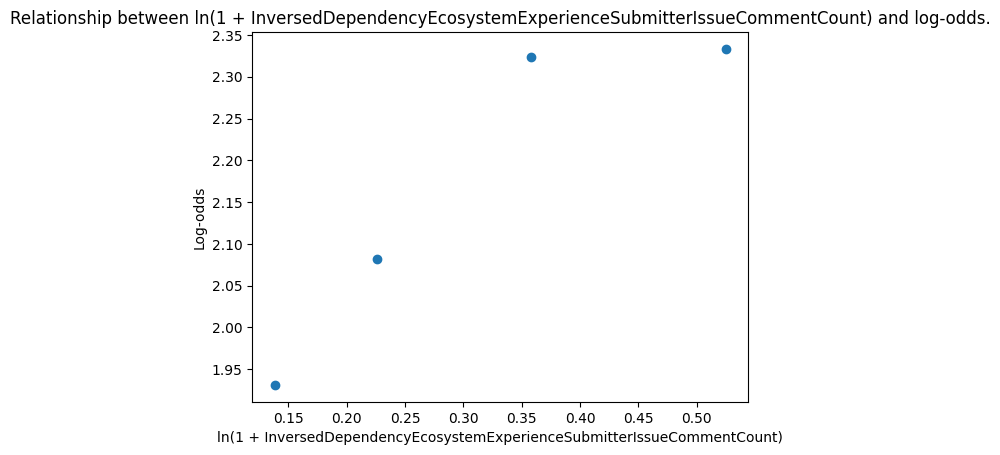

In [30]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Multicolinearity


In [42]:

# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounds
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",

    # # dep
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # Inv. dep
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",

    # intra-proj
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 13 / 23 fields to account for multicollinearity.


In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                            variable       VIF
0                        ControlIntegratedBySameUser  2.529612
1                      ControlPullRequestHasComments  3.421067
2                     ControlHasHashTagInDescription  1.586018
3                    SubmitterIsFirstTimeContributor  1.244635
4         ControlPullRequestHasCommentByExternalUser  1.973861
5        ln(1 + ControlPullRequestLifeTimeInMinutes)  4.161455
6        ln(1 + ControlNumberOfCommitsInPullRequest)  3.794426
7  ln(1 + DependencyEcosystemExperienceSubmitterP...  1.762601
8  ln(1 + InversedDependencyEcosystemExperienceSu...  1.406577
9  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.570697


In [44]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 0.
Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[
    [
        "ControlPullRequestHasComments",
        "ControlPullRequestHasCommentByExternalUser",
        0.5402706711433043
    ]
]

Transitive closure of correlating pairs:
[
    [
        "ControlPullRequestHasComments",
        "ControlPullRequestHasCommentByExternalUser"
    ],
    []
]


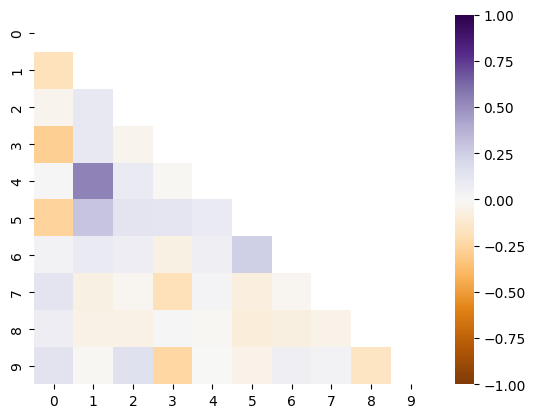

In [45]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


[[0, "ControlIntegratedBySameUser"], [1, "ControlPullRequestHasComments"], [2, "ControlHasHashTagInDescription"], [3, "SubmitterIsFirstTimeContributor"], [4, "ControlPullRequestHasCommentByExternalUser"], [5, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [6, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [7, "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [8, "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [9, "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"]]


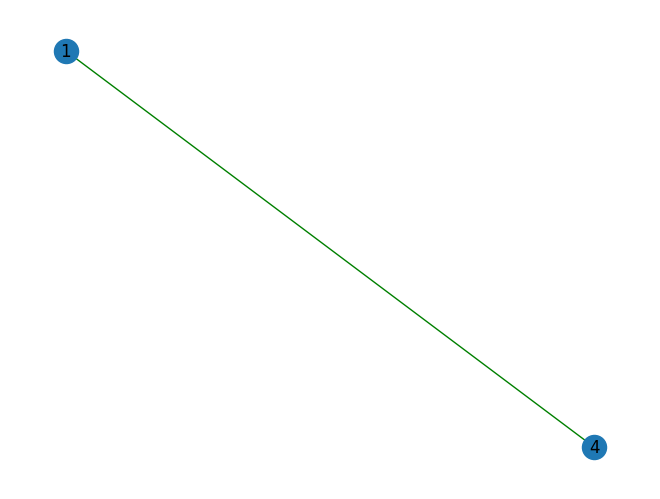

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    
    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [47]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=10
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)'],
      dtype='object')


## Outliers

Using cook's distance.


In [48]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_20037/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_20037/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
194986,0.000680,8.629135
194985,0.000577,4.332807
202202,0.000560,7.109953
108256,0.000545,10.582987
219731,0.000466,8.378734
85636,0.000461,10.185048
85430,0.000460,10.131646
85485,0.000454,9.638259
196336,0.000407,4.590638
66950,0.000394,3.335121


1.793577200046633e-05
Found outliers: 5751 / 223029 (2.579%)


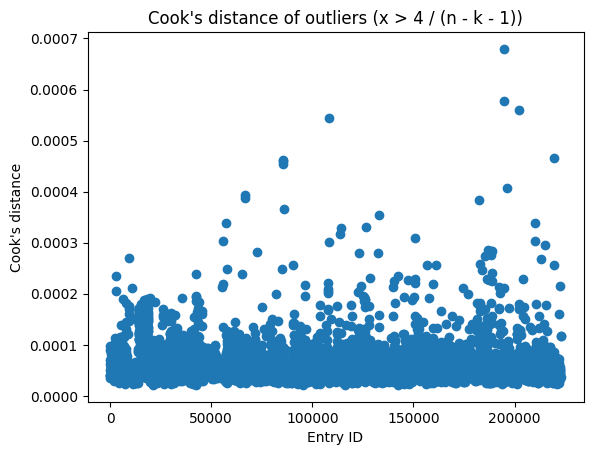

In [49]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [50]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=217278


# Model Creation

Creates a simple mixed effect logistic regression model.

In [51]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     217278                      Method:                                 REML               
No. Groups:                           8449                        Scale:                                  0.0583             
Min. group size:                      1                           Log-Likelihood:                         -21110.0782        
Max. group size:                      666                         Converged:                              Yes                
Mean group size:                      25.7                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                      -0.096    0.001  -67.267 0.000 -0.099 -0.093
ControlPullRequestHasComments                                                    -0.092    0.001  -62.158 0.000 -0.095 -0.089
ControlHasHashTagInDescription                                                    0.021    0.001   16.594 0.000  0.019  0.024
SubmitterIsFirstTimeContributor                                                  -0.047    0.002  -25.006 0.000 -0.051 -0.043
ControlPullRequestHasCommentByExternalUser                                        0.065    0.002   36.454 0.000  0.061  0.068
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.417    0.003 -129.495 0.000 -0.423 -0.411
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.345    0.009   38.544 0.000  0.327  0.362
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)          0.085    0.004   19.171 0.000  0.076  0.093
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.096    0.005   18.058 0.000  0.086  0.107
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.105    0.006   18.980 0.000  0.095  0.116
Group Var                                                                         1.165    0.079                             
=============================================================================================================================

"""

###

In [52]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'Dependency Model: {field}'] = fields[field]

print(output)
dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                                   Dependency Model: Coef.   
ControlIntegratedBySameUser                                         -0.096  \
ControlPullRequestHasComments                                       -0.092   
ControlHasHashTagInDescription                                       0.021   
SubmitterIsFirstTimeContributor                                     -0.047   
ControlPullRequestHasCommentByExternalUser                           0.065   
ln(1 + ControlPullRequestLifeTimeInMinutes)                         -0.417   
ln(1 + ControlNumberOfCommitsInPullRequest)                          0.345   
ln(1 + DependencyEcosystemExperienceSubmitterPu...                   0.085   
ln(1 + InversedDependencyEcosystemExperienceSub...                   0.096   
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                    0.105   
Group Var                                                            1.165   

                                                   Dependency M